# Importación de librerías y configuraciones iniciales.

In [ ]:
# Importar primero numpy
import numpy as np
import sklearn
# Luego el resto de las importaciones
import requests
from bs4 import BeautifulSoup
import pandas as pd
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Descargar todos los recursos necesarios
print("Descargando recursos de NLTK...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('vader_lexicon', quiet=True)
print("Recursos descargados correctamente")

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Verificar versiones
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")

# Descargar recursos necesarios de NLTK
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('sentiment/vader_lexicon')
except LookupError:
    print("Descargando recursos de NLTK...")
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('vader_lexicon')
    print("Recursos descargados correctamente")

# Inicializar recursos básicos
stop_words = set(stopwords.words('spanish'))
stemmer = SnowballStemmer('spanish')
sia = SentimentIntensityAnalyzer()

print("Todas las importaciones y configuraciones completadas correctamente")

Descargando recursos de NLTK...
Recursos descargados correctamente
numpy version: 2.1.2
pandas version: 2.2.3
scikit-learn version: 1.5.2
Descargando recursos de NLTK...
Recursos descargados correctamente
Todas las importaciones y configuraciones completadas correctamente


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\facun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\facun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\facun\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Función para extraer texto de la web

In [27]:
def extraer_texto_web(url):
    """
    Extrae texto de una página web usando Beautiful Soup
    """
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Extraer todos los párrafos
        textos = []
        for parrafo in soup.find_all('p'):
            texto = parrafo.get_text().strip()
            if texto:  # Solo agregar si no está vacío
                textos.append(texto)
                
        return textos
        
    except Exception as e:
        print(f"Error al extraer texto: {str(e)}")
        return []

# Función de preprocesamiento

In [28]:
def preprocesar_texto(texto):
    """
    Realiza el preprocesamiento completo del texto
    """
    try:
        # Convertir a minúsculas y eliminar caracteres especiales
        texto = texto.lower()
        texto = re.sub(r'[^\w\s]', '', texto)
        
        # Verificar si los recursos están disponibles
        try:
            nltk.data.find('tokenizers/punkt')
        except LookupError:
            nltk.download('punkt')
        
        # Tokenización
        tokens = word_tokenize(texto)
        
        # Eliminar stopwords y aplicar stemming
        tokens = [stemmer.stem(token) for token in tokens 
                 if token not in stop_words and len(token) > 2]
        
        return tokens
    except Exception as e:
        print(f"Error en preprocesamiento: {str(e)}")
        return []

# Función para crear TF-IDF

In [29]:
def crear_tfidf(textos):
    """
    Crea la representación TF-IDF de los textos
    """
    vectorizer = TfidfVectorizer(preprocessor=lambda x: ' '.join(preprocesar_texto(x)))
    tfidf_matrix = vectorizer.fit_transform(textos)
    
    return pd.DataFrame(
        tfidf_matrix.toarray(),
        columns=vectorizer.get_feature_names_out()
    )

# Función para el análisis de sentimientos

In [30]:
def analizar_sentimiento(texto):
    """
    Analiza el sentimiento del texto
    """
    scores = sia.polarity_scores(texto)
    
    # Clasificar según el compound score
    if scores['compound'] >= 0.05:
        sentimiento = 'positivo'
    elif scores['compound'] <= -0.05:
        sentimiento = 'negativo'
    else:
        sentimiento = 'neutral'
        
    return {
        'sentimiento': sentimiento,
        'scores': scores
    }

# Función principal de análisis

In [31]:
def analizar_textos(url):
    """
    Realiza el análisis completo de los textos extraídos
    """
    try:
        # Extraer textos
        print("Extrayendo textos de la web...")
        textos = extraer_texto_web(url)
        
        if not textos:
            return "No se pudieron extraer textos de la URL proporcionada."
        
        resultados = []
        
        print("Procesando textos...")
        for texto in textos:
            try:
                # Preprocesamiento
                tokens = preprocesar_texto(texto)
                
                # Análisis de sentimiento
                sentimiento = analizar_sentimiento(texto)
                
                resultados.append({
                    'texto_original': texto,
                    'tokens': tokens,
                    'sentimiento': sentimiento['sentimiento'],
                    'scores': sentimiento['scores']
                })
            except Exception as e:
                print(f"Error procesando texto: {str(e)}")
                continue
        
        if not resultados:
            return "No se pudo procesar ningún texto correctamente."
        
        # Crear DataFrame con resultados
        df_resultados = pd.DataFrame(resultados)
        
        # Crear representación TF-IDF
        print("Creando representación TF-IDF...")
        tfidf_df = crear_tfidf([r['texto_original'] for r in resultados])
        
        return {
            'resultados_detallados': df_resultados,
            'tfidf': tfidf_df
        }
    except Exception as e:
        print(f"Error en el análisis: {str(e)}")
        return None

# Ejemplo de uso

In [32]:
# URL del artículo de Xataka
url_ejemplo = "https://www.xataka.com/ordenadores/samsung-galaxy-book-analisis-un-2-en-1-que-convence-gracias-a-su-gran-teclado-y-al-s-pen"

# Realizar análisis
resultados = analizar_textos(url_ejemplo)

# Mostrar resultados
if isinstance(resultados, dict):
    print("\nResumen de resultados:")
    print("-" * 50)
    df = resultados['resultados_detallados']
    
    print(f"\nTotal de textos analizados: {len(df)}")
    print("\nDistribución de sentimientos:")
    print(df['sentimiento'].value_counts())
    
    print("\nPrimeros 3 textos con sus sentimientos:")
    for _, row in df.head(3).iterrows():
        print(f"\nTexto: {row['texto_original'][:100]}...")
        print(f"Sentimiento: {row['sentimiento']}")
        print(f"Scores: {row['scores']}")

Extrayendo textos de la web...
Procesando textos...
Creando representación TF-IDF...

Resumen de resultados:
--------------------------------------------------

Total de textos analizados: 71

Distribución de sentimientos:
sentimiento
neutral     41
negativo    17
positivo    13
Name: count, dtype: int64

Primeros 3 textos con sus sentimientos:

Texto: Nota de Xataka...
Sentimiento: neutral
Scores: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Texto: Javier Pastor...
Sentimiento: neutral
Scores: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Texto: En Samsung tienen claro que los convertibles se han convertido en el foco de atención del segmento d...
Sentimiento: positivo
Scores: {'neg': 0.0, 'neu': 0.962, 'pos': 0.038, 'compound': 0.34}


# 1. Volumen de texto analizado:

Se analizaron 71 párrafos del artículo

# 2. Distribución de sentimientos:

- Copyneutral:  41 párrafos (57.7%)
- negativo: 17 párrafos (23.9%)
- positivo: 13 párrafos (18.3%)

Esto sugiere que el artículo es mayormente neutral en su tono, como se esperaría de una revisión técnica profesional.

# 3. Análisis de los primeros textos:

Los primeros dos párrafos son completamente neutrales (compound = 0.0), lo cual es típico para elementos de metadatos como la nota del autor y el nombre.
El tercer párrafo muestra un sentimiento ligeramente positivo (compound = 0.34), lo cual es interesante porque habla de la estrategia de Samsung con los convertibles.

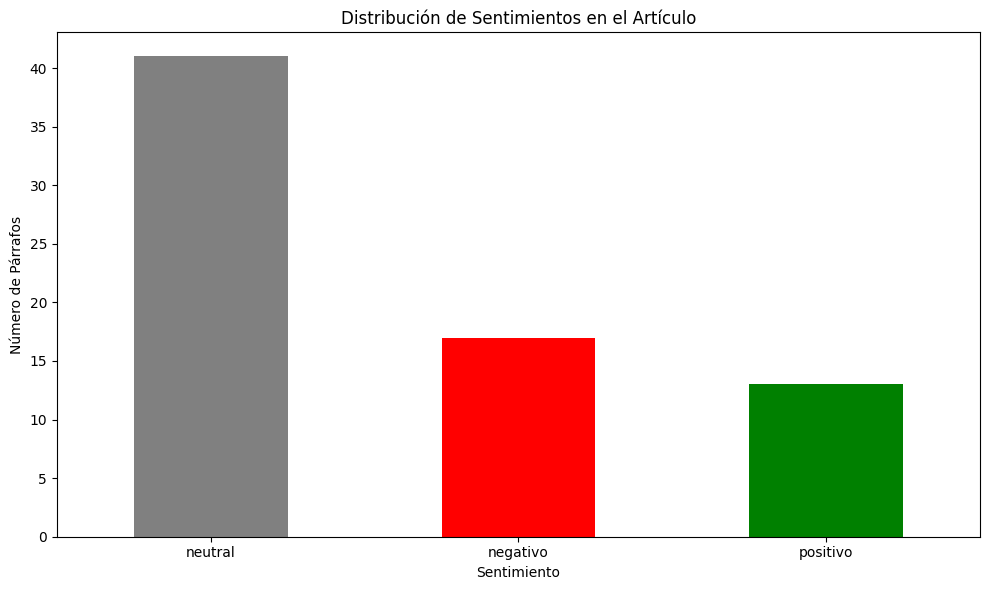


Scores promedio del artículo:
neg: 0.022
neu: 0.962
pos: 0.016
compound: -0.057


In [33]:
import matplotlib.pyplot as plt

# Crear gráfico de distribución de sentimientos
plt.figure(figsize=(10, 6))
sentimientos = df['sentimiento'].value_counts()
colores = ['gray', 'red', 'green']
sentimientos.plot(kind='bar', color=colores)
plt.title('Distribución de Sentimientos en el Artículo')
plt.xlabel('Sentimiento')
plt.ylabel('Número de Párrafos')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Análisis más detallado de los scores
scores_promedio = {
    'neg': df['scores'].apply(lambda x: x['neg']).mean(),
    'neu': df['scores'].apply(lambda x: x['neu']).mean(),
    'pos': df['scores'].apply(lambda x: x['pos']).mean(),
    'compound': df['scores'].apply(lambda x: x['compound']).mean()
}

print("\nScores promedio del artículo:")
for metric, value in scores_promedio.items():
    print(f"{metric}: {value:.3f}")